In [28]:
import sys
import os 

repo_root = os.path.abspath('..')
sys.path.append(repo_root)

from src.utils.database_manager import DatabaseManager
from src.models import boost
from src.models import tf_idf

import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np



## ML WORKFLOW

- Retrieve Unit Amenities 
- TF-IDF
- Retrieve Pricing and Other Information 
- Merge 
- Dimension Reduction
- XG boost

In [29]:

def retrieve_combined(city, state_abbr):
    db_manager = DatabaseManager('../apf.db')

    amenities_df = db_manager.retrieve_amenities(city, state_abbr)
    tf_idf_df = tf_idf.get_tf(amenities_df)
    unit_df = db_manager.retrieve_units(city, state_abbr)
    merged_df = pd.merge(tf_idf_df, unit_df, on='UnitId', how='left')

    return merged_df


In [30]:
df = retrieve_combined('austin', 'tx')
print(df.head())

8
    UnitId        10  10ft   11   12  120  128   13   14   15  ...  your  \
0  000vnf3  0.000000   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   
1  001g8z2  0.000000   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   
2  001ypl3  0.000000   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   
3  0025j52  0.445509   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   
4  0026113  0.000000   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   

   RentPrice  Beds  Baths  SquareFootage               ModelName  Latitude  \
0     1350.0     1    1.0          729.0                      A3  30.42922   
1     2650.0     2    2.0         1157.0                      B4  30.25503   
2     1250.0     1    1.0          742.0  1 Bedroom One Bathroom  30.33204   
3     1479.0     1    1.0          762.0                     A12  30.47948   
4     2062.0     3    2.0         1367.0                      C1  30.21591   

   Longitude  NumUnits      Neighborhood  
0  -97.69659        45    Sco

## Dimension Reduction


find number of components using a skree graph

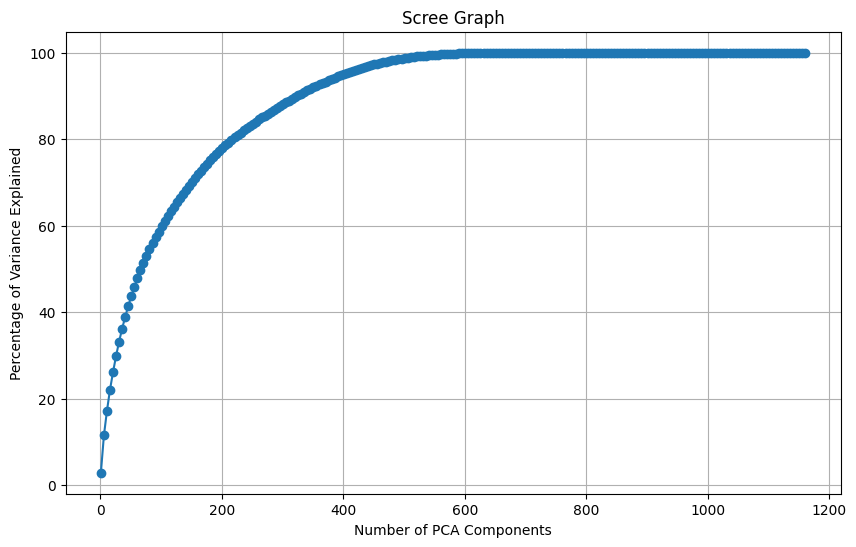

In [38]:
feature_columns = [col for col in df.columns if col not in ['UnitId', 'RentPrice', 'ModelName', 'Neighborhood']]

# Scale the features
scaler = StandardScaler()
scaled_X = scaler.fit_transform(df[feature_columns].fillna(0.0))

# Initialize PCA and fit the model to the scaled data
pca = PCA()
pca.fit(scaled_X)

# Calculate cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)
components_tested = np.arange(1, len(cumulative_explained_variance) + 1, 5)
selected_variance = cumulative_explained_variance[components_tested - 1]

plt.figure(figsize=(10, 6))
plt.plot(components_tested, selected_variance * 100, marker='o')
plt.title("Scree Graph")
plt.xlabel("Number of PCA Components")
plt.ylabel("Percentage of Variance Explained")
plt.grid(True)
plt.show()


In [ ]:
def dimension_reduction(df, n_components=50):
    pca = PCA(n_components=n_components)
    feature_columns = [col for col in df.columns if col not in ['UnitId', 'RentPrice', 'ModelName']]
    reduced_features = pca.fit_transform(df[feature_columns])
    reduced_df = pd.DataFrame(reduced_features, columns=[f'PC{i+1}' for i in range(n_components)])
    reduced_df['RentPrice'] = df['RentPrice'].values
    return reduced_df

reduced_df = dimension_reduction(df, n_components=350)

# XG boost